In [1]:
import pandas as pd
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_curve, auc

In [2]:
SEED = 30
# Set random seed for reproducibility
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# Check for CUDA availability (GPU acceleration)
is_cuda = torch.cuda.is_available()
print("Cuda Status on system is {}".format(is_cuda))

Cuda Status on system is True


In [4]:
# Load training and testing datasets using pandas' read_csv() function
train_df = pd.read_csv("./dataset/movie_train.csv")
test_df = pd.read_csv("./dataset/movie_test.csv")
print("Total training dataset shape:", train_df.shape)
print(" ")

Total training dataset shape: (32000, 2)
 


In [5]:
# Shuffle the training dataset to improve generalization
train_df = train_df.sample(n=train_df.shape[0])
# Select text and label columns for data processing
train_df = train_df[["text", "label"]]
# print(train_df.head())
# Print the distribution of labels in the training dataset
print("Label distribution of total training dataset:", train_df.label.value_counts())
print(" ")
# Print the distribution of labels in the testing dataset
print("Label distribution of total testing dataset:", test_df.label.value_counts())
print(" ")

Label distribution of total training dataset: label
1    16012
0    15988
Name: count, dtype: int64
 
Label distribution of total testing dataset: label
0    4031
1    3969
Name: count, dtype: int64
 


In [6]:
# Separate the training data into two classes based on the label
o_class = train_df.loc[train_df.label == 0, :]
l_class = train_df.loc[train_df.label == 1, :]

# Split the data into training and validation datasets
valid_o = o_class.iloc[:4000, :]
valid_l = l_class.iloc[:4000, :]
train_o = o_class.iloc[4000:, :]
train_l = l_class.iloc[4000:, :]

In [7]:
# Combine the two classes back into a single training dataset
train = pd.concat([train_o, train_l], axis=0)
# train = train.sample(n=train.shape[0])
# Print the shape of the final training dataset
print("Training dataset shape:", train.shape)
print(" ")
# Combine the two classes into a single validation dataset
valid = pd.concat([valid_o, valid_l], axis=0)
# valid = valid.sample(n=valid.shape[0])
# Print the shape of the validation dataset
print("Validation dataset shape:", valid.shape)
print(" ")
# Print the label distribution in the final training dataset
print("Label distribution of training dataset:", train.label.value_counts())
print(" ")
# Print the label distribution in the validation dataset
print("Label distribution of validation dataset:", valid.label.value_counts())
print(" ")


Training dataset shape: (24000, 2)
 
Validation dataset shape: (8000, 2)
 
Label distribution of training dataset: label
1    12012
0    11988
Name: count, dtype: int64
 
Label distribution of validation dataset: label
0    4000
1    4000
Name: count, dtype: int64
 


In [8]:
# Use SpaCy for tokenization
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [9]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

In [10]:
def build_vocab_from_dataframe(df, column_name, tokenizer, max_size):
    counter = Counter()
    for text in df[column_name]:
        counter.update(tokenizer(text))

    most_common_tokens = counter.most_common(max_size - 2)
    final_vocab = vocab(OrderedDict(most_common_tokens), specials=['<unk>', '<pad>'])
    final_vocab.set_default_index(final_vocab['<unk>'])

    return final_vocab

In [11]:
# Build a vocabulary from text data for text numericalization
max_size = 25000
train_vocab = build_vocab_from_dataframe(train, "text", tokenizer, max_size)
print(f"Total number of tokens in vocabulary: {len(train_vocab)}")

Total number of tokens in vocabulary: 25000


In [12]:
def numericalize(text, vocab, tokenizer):
    return [vocab[token] for token in tokenizer(text) if token in vocab]

In [33]:
max_seq_length = 200


def numericalize_and_pad(text, vocab, tokenizer, max_length):
    numericalized_text = [vocab[token] for token in tokenizer(text) if token in vocab]
    numericalized_text = numericalized_text[:max_length]
    padded_numericalized_text = numericalized_text + [vocab['<pad>']] * (max_length - len(numericalized_text))
    return padded_numericalized_text

In [14]:
train_numericalized_and_padded = [numericalize_and_pad(text, train_vocab, tokenizer, max_seq_length) for text in
                                  train['text']]
valid_numericalized_and_padded = [numericalize_and_pad(text, train_vocab, tokenizer, max_seq_length) for text in
                                  valid['text']]
test_numericalized_and_padded = [numericalize_and_pad(text, train_vocab, tokenizer, max_seq_length) for text in
                                 test_df['text']]

In [15]:
train_data_padded = torch.tensor(train_numericalized_and_padded, dtype=torch.long)
valid_data_padded = torch.tensor(valid_numericalized_and_padded, dtype=torch.long)
test_data_padded = torch.tensor(test_numericalized_and_padded, dtype=torch.long)

In [16]:
train_labels = torch.tensor(train['label'].values, dtype=torch.float)
valid_labels = torch.tensor(valid['label'].values, dtype=torch.float)
test_labels = torch.tensor(test_df['label'].values, dtype=torch.float)

In [17]:
train_dataset = TensorDataset(train_data_padded, train_labels)
valid_dataset = TensorDataset(valid_data_padded, valid_labels)
test_dataset = TensorDataset(test_data_padded, test_labels)

In [18]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
# Define the Vanilla RNN model structure
class VanillaRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(VanillaRNN, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        # text = [batch size, sent length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent length, emb dim]

        output, hidden = self.rnn(embedded)
        # output = [batch size, sent length, hid dim]
        # hidden = [1, batch size, hid dim]

        assert torch.equal(output[:, -1, :], hidden.squeeze(0))

        return self.fc(hidden.squeeze(0))

In [41]:
# Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM = len(train_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

In [21]:
def binary_accuracy(preds, y):
    # round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [22]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()

        text, labels = batch

        text = text.to(device)
        labels = labels.to(device)

        predictions = model(text).squeeze(1)

        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch

            text = text.to(device)
            labels = labels.to(device)

            predictions = model(text).squeeze(1)

            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [70]:
N_EPOCHS = 40
model = VanillaRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

best_valid_loss = float('inf')

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [71]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "./checkpoints/rnn_model_saved")

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 0.700 | Train Acc: 49.99%
	 Val. Loss: 0.693 |  Val. Acc: 51.01%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.693 | Train Acc: 51.65%
	 Val. Loss: 0.695 |  Val. Acc: 50.55%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.694 | Train Acc: 51.75%
	 Val. Loss: 0.715 |  Val. Acc: 49.59%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.685 | Train Acc: 54.57%
	 Val. Loss: 0.697 |  Val. Acc: 49.62%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.679 | Train Acc: 55.33%
	 Val. Loss: 0.699 |  Val. Acc: 51.92%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.656 | Train Acc: 58.59%
	 Val. Loss: 0.708 |  Val. Acc: 54.73%
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 0.635 | Train Acc: 60.75%
	 Val. Loss: 0.706 |  Val. Acc: 54.36%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.585 | Train Acc: 64.60%
	 Val. Loss: 0.719 |  Val. Acc: 55.24%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.573 | Train Acc: 64.95%
	 Val. Loss: 0.722 |  Val. Acc: 55.83%
Epoch: 10 | Epoch Time: 0m 2

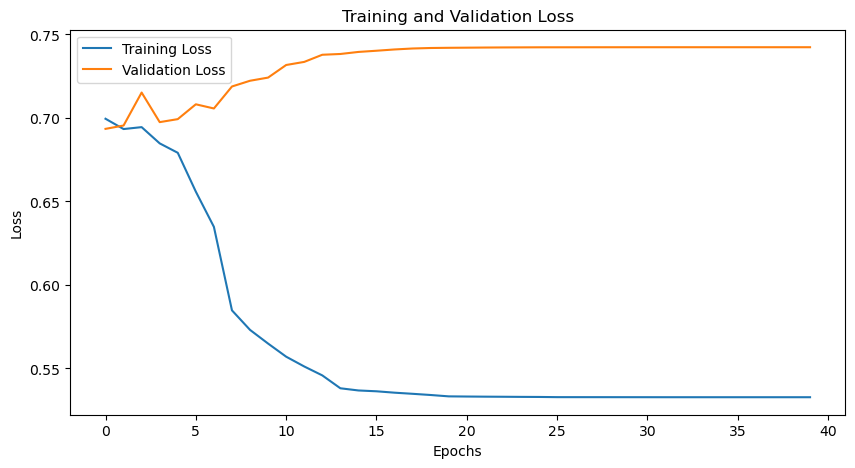

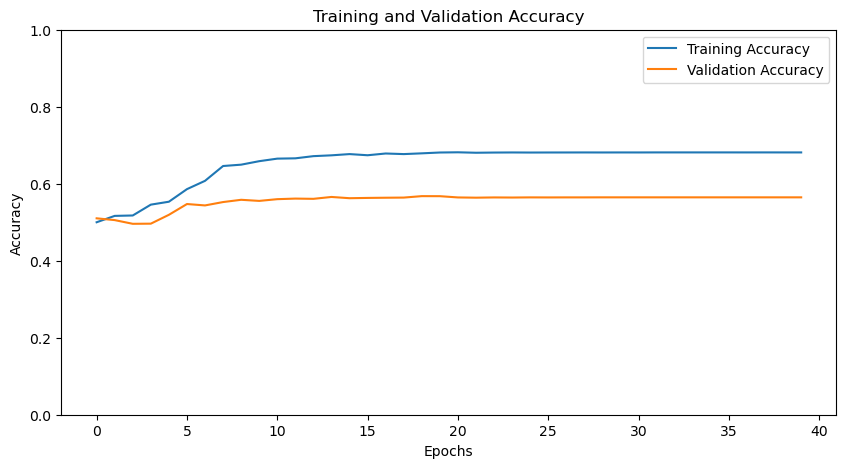

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [73]:
def evaluate_with_roc(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    # These lists will store the true labels and prediction probabilities
    true_labels = []
    prediction_probs = []

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            true_labels.extend(labels.cpu().detach().numpy())
            prediction_probs.extend(torch.sigmoid(predictions).cpu().detach().numpy())

    # Compute ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, prediction_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), roc_auc

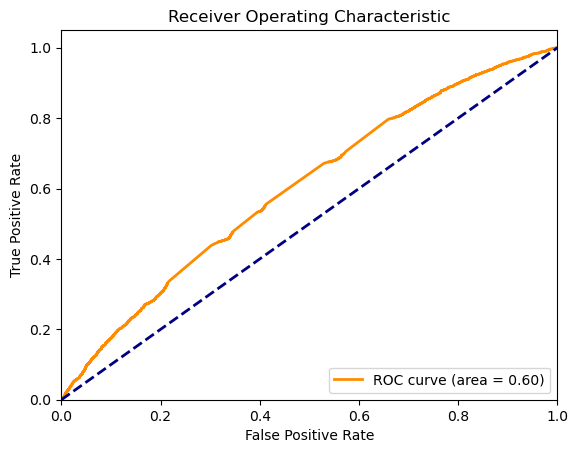

Test Loss: 0.753 | Test Acc: 0.56% | Test AUC: 0.60


In [74]:
test_loss, test_acc, test_auc = evaluate_with_roc(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}% | Test AUC: {test_auc:.2f}')

In [75]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # 使用LSTM代替RNN
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        # LSTM的输出包括所有时刻的隐状态以及最后一个时刻的隐状态和细胞状态
        output, (hidden, cell) = self.lstm(embedded)

        # 使用最后一个时刻的隐状态
        hidden = hidden.squeeze(0)

        return self.fc(hidden)

In [76]:
model = LSTMModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

In [77]:
N_EPOCHS = 15
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

best_valid_loss = float('inf')

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

model.train()

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "checkpoints/lstm_model_saved")

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.694 | Train Acc: 51.07%
	 Val. Loss: 0.684 |  Val. Acc: 54.65%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.689 | Train Acc: 52.25%
	 Val. Loss: 0.687 |  Val. Acc: 53.44%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.670 | Train Acc: 57.88%
	 Val. Loss: 0.653 |  Val. Acc: 64.01%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.615 | Train Acc: 66.63%
	 Val. Loss: 0.607 |  Val. Acc: 68.51%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.522 | Train Acc: 75.59%
	 Val. Loss: 0.686 |  Val. Acc: 67.81%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.442 | Train Acc: 80.81%
	 Val. Loss: 0.493 |  Val. Acc: 77.81%
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.335 | Train Acc: 86.48%
	 Val. Loss: 0.474 |  Val. Acc: 80.47%
Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.260 | Train Acc: 89.94%
	 Val. Loss: 0.491 |  Val. Acc: 78.53%
Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.202 | Train Acc: 92.75%
	 Val. Loss: 0.483 |  Val. Acc: 80.83%
Epoch: 10 | Epoch Time: 0m 5

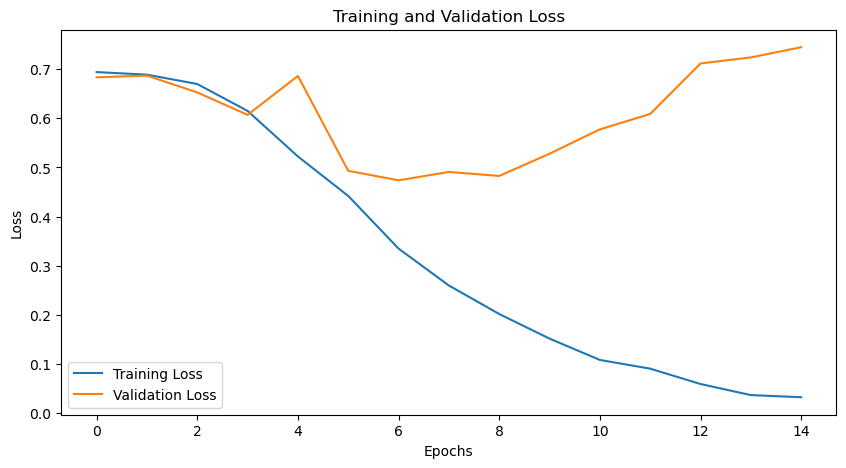

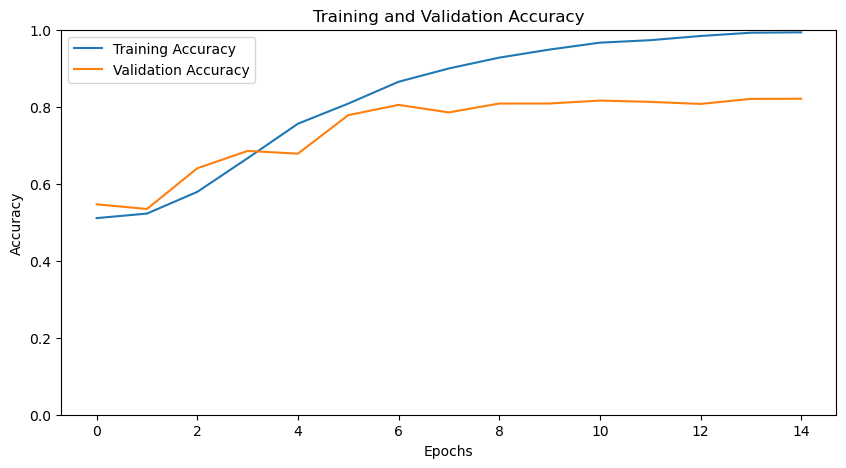

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

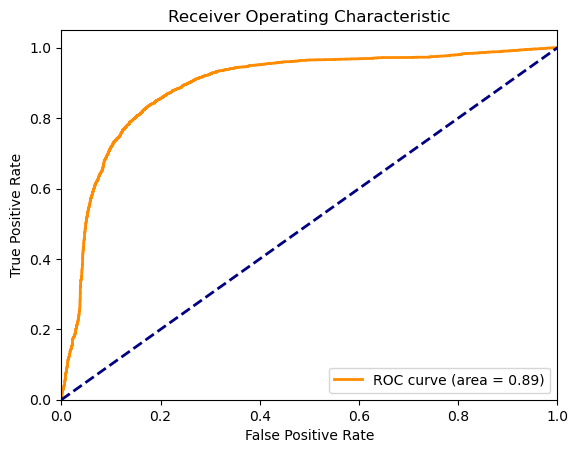

Test Loss: 0.702 | Test Acc: 82.85% | Test AUC: 0.89


In [79]:
test_loss, test_acc, test_auc = evaluate_with_roc(model, test_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}% | Test AUC: {test_auc:.2f}')

In [80]:
SEED = 20
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 8
MAX_LEN = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(SEED)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [81]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [82]:
df = pd.read_csv("./dataset/movie_train.csv")
df_train, df_val = train_test_split(df, test_size=0.25, random_state=SEED)
df_test = pd.read_csv("./dataset/movie_test.csv")

train_dataset = IMDBDataset(
    texts=df_train.text.to_numpy(),
    labels=df_train.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = IMDBDataset(
    texts=df_test.text.to_numpy(),
    labels=df_test.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = IMDBDataset(
    texts=df_test.text.to_numpy(),
    labels=df_test.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)
test_size = len(test_loader.dataset)
print(f"Training Set Size: {train_size}")
print(f"Validation Set Size: {val_size}")
print(f"Test Set Size: {test_size}")

Training Set Size: 24000
Validation Set Size: 8000
Test Set Size: 8000


In [83]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\anaconda3\envs\pytorch\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [84]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in tqdm(data_loader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        preds = torch.argmax(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)


def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for data in tqdm(data_loader):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            preds = torch.argmax(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [85]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        scheduler
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    print()
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        device
    )
    valid_losses.append(val_loss)
    valid_accuracies.append(val_acc.item())
    print()
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

Epoch 1/8
----------


100%|██████████| 1500/1500 [05:14<00:00,  4.77it/s]



Train loss 0.33081405723839996 accuracy 0.8533333333333333


100%|██████████| 500/500 [00:46<00:00, 10.84it/s]



Val   loss 0.2660844316035509 accuracy 0.88525

Epoch 2/8
----------


100%|██████████| 1500/1500 [05:13<00:00,  4.78it/s]



Train loss 0.18156380930822344 accuracy 0.9306249999999999


100%|██████████| 500/500 [00:46<00:00, 10.85it/s]



Val   loss 0.29360965264588595 accuracy 0.8835000000000001

Epoch 3/8
----------


100%|██████████| 1500/1500 [05:14<00:00,  4.78it/s]



Train loss 0.08375217356113716 accuracy 0.9717916666666666


100%|██████████| 500/500 [00:46<00:00, 10.87it/s]



Val   loss 0.37019686423568055 accuracy 0.889625

Epoch 4/8
----------


100%|██████████| 1500/1500 [05:14<00:00,  4.77it/s]



Train loss 0.035869091801151325 accuracy 0.9889166666666667


100%|██████████| 500/500 [00:46<00:00, 10.86it/s]



Val   loss 0.4827264486919157 accuracy 0.885625

Epoch 5/8
----------


100%|██████████| 1500/1500 [05:14<00:00,  4.77it/s]



Train loss 0.020002537135228825 accuracy 0.9939166666666667


100%|██████████| 500/500 [00:46<00:00, 10.84it/s]



Val   loss 0.535780955407885 accuracy 0.885875

Epoch 6/8
----------


100%|██████████| 1500/1500 [05:28<00:00,  4.57it/s]



Train loss 0.012022748061319968 accuracy 0.9967916666666666


100%|██████████| 500/500 [00:46<00:00, 10.84it/s]



Val   loss 0.5703268660710892 accuracy 0.886625

Epoch 7/8
----------


100%|██████████| 1500/1500 [05:14<00:00,  4.78it/s]



Train loss 0.006905605299029655 accuracy 0.9982916666666667


100%|██████████| 500/500 [00:46<00:00, 10.83it/s]



Val   loss 0.6331858497919748 accuracy 0.888125

Epoch 8/8
----------


100%|██████████| 1500/1500 [05:14<00:00,  4.77it/s]



Train loss 0.005116411103658417 accuracy 0.9987916666666666


100%|██████████| 500/500 [00:46<00:00, 10.82it/s]



Val   loss 0.6316336693888297 accuracy 0.889


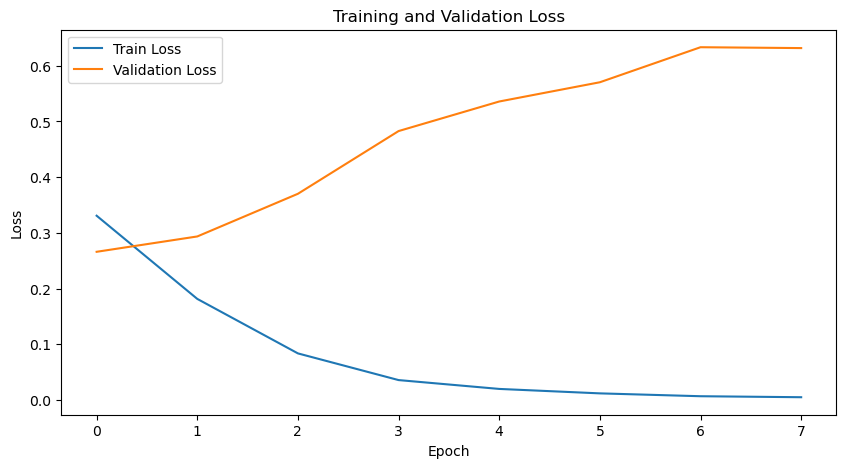

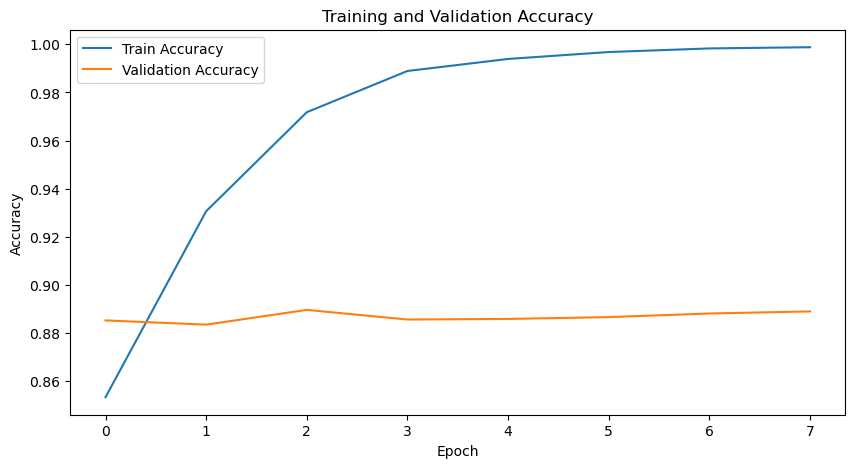

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [87]:
def evaluate_test_set_with_roc(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    actual_labels = []
    predicted_probs = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            preds = torch.argmax(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            actual_labels.extend(labels.cpu().numpy())
            predicted_probs.extend(outputs.logits.softmax(dim=1)[:,1].cpu().numpy())

    accuracy = correct_predictions.double() / len(data_loader.dataset)
    mean_loss = np.mean(losses)

    # Calculate ROC AUC
    fpr, tpr, thresholds = roc_curve(actual_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for Test Set')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy, mean_loss, roc_auc

100%|██████████| 500/500 [00:46<00:00, 10.75it/s]


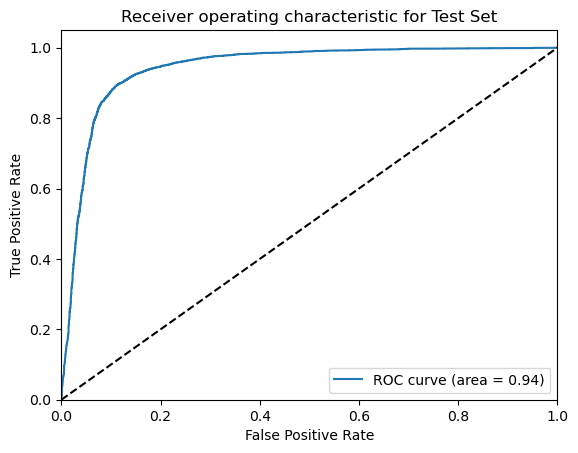

Test Loss: 0.632 | Test Accuracy: 0.89 | Test AUC: 0.94


In [88]:
test_acc, test_loss, test_auc = evaluate_test_set_with_roc(model, test_loader, device)

print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc:.2f} | Test AUC: {test_auc:.2f}')

# EE7207 Assignment Report
In this assignment, the task of sentiment analysis on the IMDB movie reviews dataset was addressed, aiming to classify reviews into positive or negative categories. The approach involved data preprocessing, model selection, training, and evaluation.

## Data Exploration
Preprocessing the data is the first procedure. Given that the dataset comprises solely a test set and a training set, I partitioned the training set into a validation set (25%) and a training set (75%), ensuring that the proportion of positive to negative comments in each set was approximately equivalent. After that, in the training of RNN and LSTM, I employed the tokenizer from the spacy library to tokenize the comments in the training set. However, I observed that the number of tokens reached a staggering 120000. To mitigate this issue and enhance the efficiency of the model training, I chose to keep only the top 25000 words with the highest frequency as the vocabulary list. Besides, due to the limitations of the RNN structure, it is necessary for the inputs to have the same dimension. In order to achieve this goal, short comments are padded to match the dimension of the longest comment. Nevertheless, such padding causes the useful information to be spread out, resulting in poor training of the RNN and LSTM. I addressed the issue of different comment lengths by establishing an appropriate maximum sequence length. I then either added padding to shorter comments or truncated longer ones to maintain consistency and verify that input sizes are correct and suitable.

For the data preprocessing stage of the BERT model, a different strategy was employed. Firstly, BertTokenizer from the transformers library was used for tokenizing the texts. Unlike the tokenizer from the spacy library used for RNN and LSTM, BertTokenizer is optimized specifically for BERT, capable of directly processing texts and converting them into a format required by the model. This includes converting words into indices in the vocabulary, adding special tokens (like CLS and SEP), and generating attention masks. This step automatically takes into account the maximum sequence length limitation of the BERT model (usually 512 tokens). Therefore, during preprocessing, an appropriate maximum sequence length 128 was set to balance processing speed and performance. Sequences exceeding this length were truncated, while shorter sequences were padded to ensure a fixed length.

## Model Selection

As for the selected models, we initially selected a Vanilla Recurrent Neural Network (RNN) model for sentiment analysis because of its ability to effectively process sequential input. However, the performance of the system is inadequate due to the constraints of Recurrent Neural Networks (RNN) in effectively capturing long-term dependencies. Consequently, the subsequent model employed is the Long Short-Term Memory (LSTM), an enhanced Recurrent Neural Network (RNN) that possesses the ability to acquire long-term dependencies in contrast to the Vanilla RNN. Furthermore, the LSTM model exhibits a substantial enhancement in performance when compared to the Vanilla RNN. This improvement also serves as evidence that effectively capturing long-term dependencies is crucial for sentiment analysis tasks involving lengthy sequences.

In addition to the Vanilla RNN and LSTM models, the BERT (Bidirectional Encoder Representations from Transformers) model was chosen for its state-of-the-art performance in various NLP tasks, including sentiment analysis. Unlike RNNs and LSTMs that process data sequentially, BERT utilizes the transformer architecture, which allows it to process the entire sequence of tokens at once. This characteristic enables BERT to capture context from both directions (left and right of a token) simultaneously, providing a more comprehensive understanding of the text. Secondly, I used the pre-trained BERT model from Hugging Face, brings the advantage of transfer learning to sentiment analysis. This approach significantly enhances the model's ability to understand complex language patterns and nuances, leading to superior performance in classifying sentiments compared to the traditional RNN and LSTM models.

## Evaluation Metrics

I used accuracy and AUC value as the main evaluation metrics. Accuracy measures the percentage of correctly predicted instances out of the total number of predictions. The AUC value is the area under the ROC curve, which evaluates the strength of the classifier.

## Performance Analysis

The Vanilla RNN achieved a training set accuracy of 68.13%, a validation set accuracy of 56.46%, a test set accuracy of 56% and AUC value is 0.60. These findings indicate that although the model has acquired knowledge to a satisfactory degree from the training data, there is a significant decline in its performance when applied to the unseen validation and test data. The decrease in performance suggests that the model has limitations in its ability to apply knowledge beyond the material it was trained on. This is likely because RNNs struggle with capturing long-term relationships in text data. In contrast, the LSTM model had an impressive training set accuracy of 99.81%, as well as a validation set accuracy of 83.34%, a test set accuracy of 83.73% and AUC value is 0.89. The higher training accuracy suggests that the LSTM model has successfully acquired knowledge from the training data. The LSTM model demonstrates improved generalisation ability by achieving comparatively high validation and test accuracies compared to the RNN model. The improved performance can be credited to the architecture of LSTM, which is specifically designed to address the limitations of standard RNNs by effectively capturing long-term dependencies in sequential data. However, it is evident from the loss curve that there is indeed a presence of overfitting occurring after 8 epochs. The primary reason for this is the lack of sufficient data to extensively train the model, resulting in an inability to generalise to new, unseen data.

The BERT model achieved a training set accuracy of 99.8%, with validation and test set accuracies of 88.9% and 89% respectively. The achieved AUC value of 0.94 surpasses the performance of the classic RNN and LSTM models in this sentiment analysis assignment. This is due to its profound comprehension of context and semantics acquired through pre-training on an extensive collection of textual data. However, employing a pre-trained BERT model also has its drawbacks, as the insufficiency of training data leads to early overfitting, preventing the model from achieving better results on the validation and test sets.

## Encountered Challenges

A major challenge I encountered was the scattering of useful information caused by excessive padding of brief sequences, and the elevated computational intricacy resulting from extensive vocabulary lists. I experimented with reducing the vocabulary size and sequence length, which proved to be beneficial, as well as finding the suitable sequence length 200 that could achieve higher accuracy for RNNs and LSTMs.

Another challenge encountered is that for RNN, LSTM and BERT, overfitting occurs at higher epochs. To solve this problem, I used a learning rate scheduler, such as learning rate decay, which can gradually reduce the learning rate during training to help the model converge better. However, it did not alleviate the overfitting problem too much. I suggest that adding more training data can effectively mitigate overfitting and improve the generalization ability of the model.

## Conclusion

In conclusion, when comparing RNNs to LSTM and BERT, it is evident that LSTM and BERT outperform RNNs in handling long sequences and extended time periods. BERT, in particular, utilises a transformer architecture that allows it to process the entire labelled sequence simultaneously, resulting in superior classification performance compared to LSTM.